In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tanzania import Colors, save_png

Colors.init_colors()


In [2]:
train_data = pd.read_csv('data/Train.csv')
train_data.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0


In [3]:
train_data.drop('ID', axis=1, inplace=True)
train_data.shape

(4809, 22)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                4809 non-null   object 
 1   age_group              4809 non-null   object 
 2   travel_with            3695 non-null   object 
 3   total_female           4806 non-null   float64
 4   total_male             4804 non-null   float64
 5   purpose                4809 non-null   object 
 6   main_activity          4809 non-null   object 
 7   info_source            4809 non-null   object 
 8   tour_arrangement       4809 non-null   object 
 9   package_transport_int  4809 non-null   object 
 10  package_accomodation   4809 non-null   object 
 11  package_food           4809 non-null   object 
 12  package_transport_tz   4809 non-null   object 
 13  package_sightseeing    4809 non-null   object 
 14  package_guided_tour    4809 non-null   object 
 15  pack

In [5]:
cat_cols = [c for c in train_data.columns if train_data[c].dtype == 'object']
num_cols = [c for c in train_data.columns if c not in cat_cols]

print(f'categorical features: {len(cat_cols)}, numerical features: {len(num_cols) - 1}')

categorical features: 17, numerical features: 4


In [6]:
train_data.isna().sum().sum()

1435

In [7]:
# sns.pairplot(train_data)

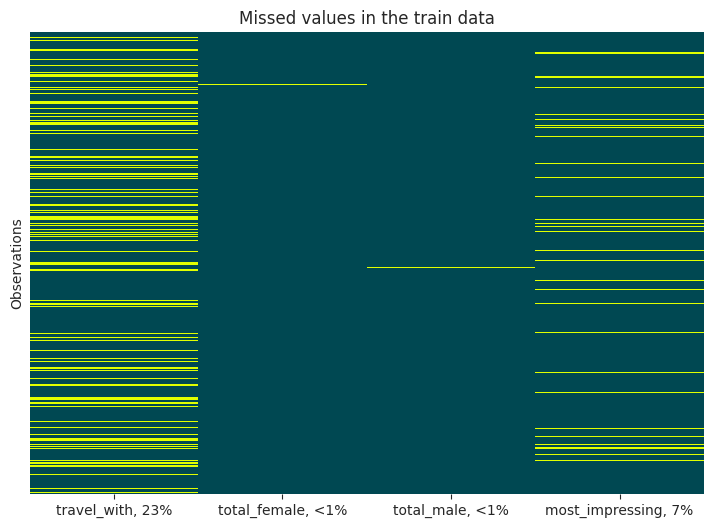

In [ ]:
# prepare missed values map

plt.figure(figsize=(8.7, 6))
ax = sns.heatmap(
    train_data[['travel_with', 'total_female', 'total_male', 'most_impressing']].isnull(),
    xticklabels=['travel_with, 23%', 'total_female, <1%', 'total_male, <1%', 'most_impressing, 7%'],
    cbar=False,
    cmap=Colors.colormap,
    yticklabels=False)

ax.set_title('Missed values in the train data')
ax.set_ylabel('Observations')

save_png('pics/nan_values.png')
plt.show()


In [ ]:
from matplotlib.patches import Patch

people = train_data[['travel_with', 'total_male', 'total_female']].dropna(axis = 0, how='any')
people_alone = people.query('total_male + total_female == 1').dropna(how = 'any')
people_not_alone = people.query('total_male + total_female != 1').dropna(how = 'any')

order = ['Alone', 'Spouse', 'Friends/Relatives', 'Spouse and Children', 'Children']

current_palette = Colors.palette[:len(order)]
color_dict = dict(zip(order, current_palette))

legend_elements = [Patch(facecolor=color_dict[cat], label=cat) for cat in order]

fig, axes = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(
    data = people_alone,
    x = 'travel_with',
    ax = axes[0],
    order = order,
    palette = color_dict
)
axes[0].set_title('What people saying, when sum of total_male and female is 1')
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].set_xticklabels([])
axes[0].legend(handles=legend_elements, title="", frameon = False)

sns.countplot(
    data = people_not_alone,
    x = 'travel_with',
    ax = axes[1],
    order = order,
    palette = color_dict
)
axes[1].set_title('What people saying, when sum of total_male and female is not 1')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_xticklabels([])
axes[1].legend(handles=legend_elements, title="", frameon = False)

plt.ylim(top=1350)

save_png('pics/people_travel_with.png')
plt.show()


What if all the packages just are part of the price? Can I compose them to a feature like 'package'. just kind of their sum. This shoudl correlate with the price

In [ ]:
from sklearn.linear_model import LinearRegression
cat_cols = [c for c in train_data.columns if train_data[c].dtype == 'object']
num_cols = [c for c in train_data.columns if c not in cat_cols]

def get_categorical_corellation(data: pd.DataFrame, col: str, target: str) -> float:
    dummies = pd.get_dummies(data[col], drop_first=True)
    X = dummies
    y = data[target]

    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    correlation = y.corr(pd.Series(y_pred))
    return correlation

# keep here corellations for all the features (name, value)
corrs = []
for col in cat_cols:
    corrs.append((col, get_categorical_corellation(train_data, col, "total_cost").round(2)))

print(cat_cols)
print(num_cols)


In [ ]:
package_cols = [
    'package_accomodation',
    'package_transport_int',
    'package_food',
    'package_transport_tz',
    'package_sightseeing',
    'package_guided_tour',
    'package_insurance'
]

def count_packages(row: pd.Series):
    val = 0
    for col in package_cols:
        val += (1 if row[col] == 'Yes' else 0)
    return val

def count_weigthed_packages(row: pd.Series, correlations: list) -> pd.DataFrame:
    val = 0
    for col in package_cols:
        cor = next((corr for corr in correlations if corr[0] == col), None)[1]
        val += cor * (1 if row[col] == 'Yes' else 0)
    return val

train_data['package'] = train_data.apply(count_packages, axis = 1)
train_data['package_weighted'] = train_data.apply(lambda row: count_weigthed_packages(row, corrs), axis = 1)

num_cols.extend(['package', 'package_weighted'])

train_data

In [ ]:
# collect all the corellations for all the 

num_cors = train_data[num_cols].corr()['total_cost']

for col in num_cors.index:
    if col != 'total_cost':
        corrs.append((col, num_cors[col].round(2)))


In [ ]:
# sort correlations
sorted_corellations = sorted(corrs, key = lambda x: x[1], reverse=True )
for c in sorted_corellations:
    print(f'corellation total_cost to {c[0]} : {c[1]}')

len(sorted_corellations)


In [ ]:
series_x = [pair[0] for pair in sorted_corellations]
series_y = [pair[1] for pair in sorted_corellations]

plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    x = series_x, y = series_y
)
ax.set_title('Features corellation to "total_cost" target')
ax.set_ylabel('corellation')
plt.xticks(rotation=75)

save_png('pics/feature_corellation.png')

plt.show()